In [1]:
# -*- coding: utf-8 -*-
""" 
mainTRG.py
---------------------------------------------------------------------
Script file for initializing a partition function (here the classical \
Ising model) before passing to a Tensor Renormalization Group (TRG) \
coarse-graining routine. The magnetization, free energy and internal \
energy are then computed and compared against the exact results.

by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 26/1/2019
"""

#### Preamble
import numpy as np
from numpy import linalg as LA

from ncon import ncon
from doTRG import doTRG 

import matplotlib.pyplot as plt

In [2]:
def iterTRG(numlevels, Tval):
    ##### Example 1: square lattice classical Ising model #####
    ###########################################################

    ##### Set bond dimensions and temperature
    chiM = 32
    chiH = 32
    chiV = 32
    
    OPTS_midsteps = 10 # iterations in isometry optimization

    ##### Define partition function (classical Ising)
    
    betaval = 1/Tval
    Jtemp = np.zeros((2,2,2)); Jtemp[0,0,0]=1; Jtemp[1,1,1]=1
    Etemp = np.array([[np.exp(betaval),np.exp(-betaval)],[np.exp(-betaval),np.exp(betaval)]])

    Ainit = ncon([Jtemp,Jtemp,Jtemp,Jtemp,Etemp,Etemp,Etemp,Etemp],
             [[-1,8,1],[-2,2,3],[-3,4,5],[-4,6,7],[1,2],[3,4],[5,6],[7,8]])
    Atemp = Ainit.reshape(2,2,2,2)

    Anorm = [0 for x in range(numlevels+1)]
    Anorm[0] = LA.norm(Atemp.flatten())
    A = [0 for x in range(numlevels+1)]
    A[0] = Atemp/Anorm[0]

    ##### Do iterations of TRG
    SPerrs = np.zeros((numlevels,3))
    qC = [0 for x in range(numlevels)]
    vC = [0 for x in range(numlevels)]
    wC = [0 for x in range(numlevels)]
    for k in range(numlevels):
        A[k+1], qC[k], vC[k], wC[k], Anorm[k+1], SPerrs[k,:] = doTRG(A[k],chiM,chiH,chiV, midsteps = OPTS_midsteps)
        #print('RGstep: %d, Truncation Errors: %e, %e, %e' % (k,SPerrs[k,0],SPerrs[k,1],SPerrs[k,2]))
    return A, vC, wC, Anorm


In [3]:
"""
evalTRG: evaluates outputs from TNR algorithm to compute several \
quantities for the Ising model (free energy, internal energy)
"""
def evalTRG(numlevels, Tval, A, vC, wC, Anorm):

    ##### Evaluate free energy density as a function of system size
    NumSpins = 2**(2*np.int64(np.array(range(20)))+1)
    FreeEnergy = np.zeros(numlevels);
    for k in range(1,numlevels+1): 
        FreeEnergy[k-1] = -Tval*(sum((4**np.int64(np.array(range(k,-1,-1))))*np.log(Anorm[:(k+1)])) +
                  np.log(ncon([A[k]],[[1,2,1,2]]))) / NumSpins[k]

    ##### Evaluate local density matrix, internal energy, spontaneous mag
    maglambda = 1/(np.sinh(2/Tval)**2) # mag field (quantum Ising) from temp (classical Ising)
    betaval = 1/Tval

    sX = np.array([[1, 0], [0,-1]])
    sXsX = np.kron(sX,sX).reshape(2,2,2,2) # spin1 - 1,3; spin2 - 2,4


    sXcg = [0 for x in range(numlevels+1)]
    sXcg[0] = sX

    sXsXcgtemp = [0 for x in range(numlevels+1)]
    sXsXcgtemp[0] = sXsX

    ExpectXX = [0 for x in range(numlevels-1)]

    base = ncon([A[numlevels]],[[1,2,1,2]])
    #print('base: ', base)

    for k in range(numlevels):
        sXcg[k+1] = ncon([sXcg[k],wC[k],wC[k]],[[1,2],[1,3,-1],[2,3,-2]])
    
    for x in range(numlevels-1):
        sXsXcgtemp[x+1] = ncon([sXsXcgtemp[x],vC[x],vC[x]],[[1,2,3,4],[1,2,-1],[3,4,-2]])
        
        for k in range(x+1, numlevels): 
            sXsXcgtemp[k+1] = ncon([sXsXcgtemp[k],vC[k],vC[k]],[[1,2],[1,3,-1],[2,3,-2]])

        cal = ncon([A[numlevels], sXsXcgtemp[numlevels]],[[1,2,3,2],[1,3]])

        sXsXcgtemp[x+1] = ncon([sXsXcgtemp[x],vC[x],vC[x],vC[x],vC[x]],[[1,2,3,4],[1,5,-1],[3,5,-3],[2,6,-2],[4,6,-4]])
    
        #print('cal: ', cal)
        ExpectXX[x] = cal/base
    
    dtemp = LA.eigvalsh(sXcg[numlevels])
    ExpectX = max(abs(dtemp))
    
    ##### Compare with exact results (thermodynamic limit)
    N = 1000000
    x = np.linspace(0,np.pi,N+1)
    y = np.log(np.cosh(2*betaval)*np.cosh(2*betaval) + (1/maglambda)*np.sqrt(
            1+maglambda**2 -2*maglambda*np.cos(2*x)))
    FreeExact = -Tval*((np.log(2)/2) + 0.25*sum(y[1:(N+1)] + y[:N])/N)
    
    ExpectXExact = 0
    if maglambda < 1:
        ExpectXExact = (1 - np.sinh(2*betaval)**(-4))**(1/8)
    
    return FreeEnergy[numlevels-1], FreeExact, ExpectX, ExpectXExact, ExpectXX

In [4]:
##### Example 1: square lattice classical Ising model #####
###########################################################

N = 50
numlevels = 16 # number of coarse-grainings
Tc = (2/np.log(1+np.sqrt(2)))
relTemp = np.linspace(0.01, 2.0, N)
T = relTemp*Tc

FreeEnergy = [0 for x in range(N)]
FreeExact = [0 for x in range(N)]
ExpectX = [0 for x in range(N)]
ExpectXExact = [0 for x in range(N)]
ExpectXX = [0 for x in range(N)]

for i in range(N):
    Tval  = T[i]
    #----------------------------------------------------
    # Evaluate obserables of interest
    A, vC, wC, Anorm = iterTRG(numlevels, Tval)
    FreeEnergy[i], FreeExact[i], ExpectX[i], ExpectXExact[i], ExpectXX[i] = evalTRG(numlevels, Tval, A, vC, wC, Anorm)
    print('Tenperature: %f, FreeEnergy: %f, FreeExact: %f, ExpectX: %f, ExpectXExact: %f' % (Tval, FreeEnergy[i], FreeExact[i], ExpectX[i], ExpectXExact[i]))
    print('ExpectXX: ', ExpectXX[i])

Tenperature: 0.022692, FreeEnergy: -2.000000, FreeExact: -2.000000, ExpectX: 1.000000, ExpectXExact: 1.000000
ExpectXX:  [1.0000000000000018, 1.0000000000000018, 1.0000000000000022, 1.0000000000000029, 1.000000000000003, 1.000000000000004, 1.0000000000000036, 1.0000000000000044, 1.0000000000000042, 1.0000000000000038, 1.000000000000005, 1.000000000000004, 1.0000000000000044, 1.0000000000000044, 1.0000000000000044]
Tenperature: 0.114849, FreeEnergy: -2.000000, FreeExact: -2.000000, ExpectX: 1.000000, ExpectXExact: 1.000000
ExpectXX:  [1.0000000000000018, 1.0000000000000024, 1.0000000000000024, 1.0000000000000022, 1.0000000000000022, 1.0000000000000013, 1.0000000000000018, 1.0000000000000024, 1.0000000000000018, 1.0000000000000022, 1.000000000000003, 1.0000000000000029, 1.000000000000003, 1.0000000000000038, 1.0000000000000033]
Tenperature: 0.207005, FreeEnergy: -2.000000, FreeExact: -2.000000, ExpectX: 1.000000, ExpectXExact: 1.000000
ExpectXX:  [1.0000000000000009, 1.000000000000001, 1

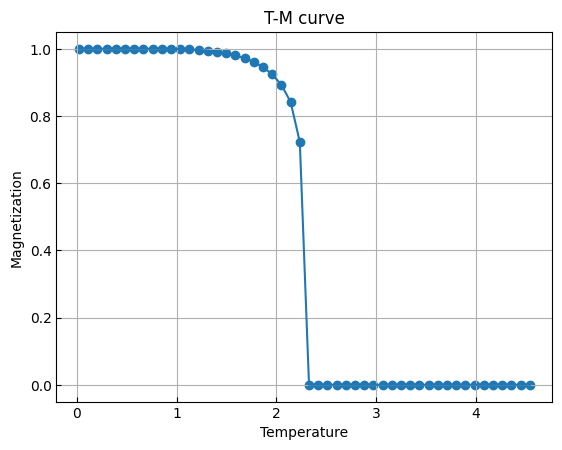

In [5]:
# 绘制曲线
plt.plot(T, ExpectXExact)
plt.scatter(T, ExpectX)

plt.tick_params(direction='in') 

# 添加网格线
plt.grid(True)

# 添加标签和标题
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.title('T-M curve')

# 显示图形
plt.show()

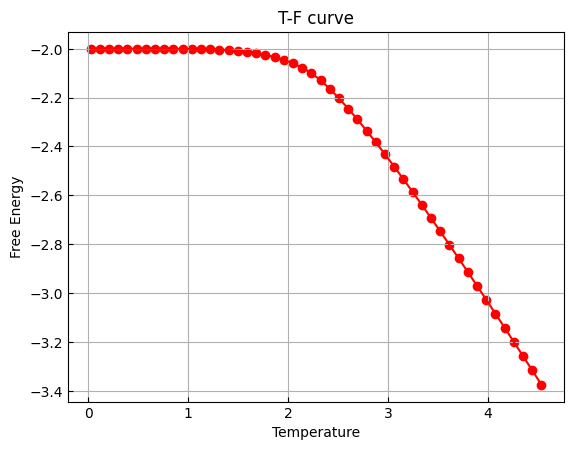

In [6]:
# 绘制曲线
plt.plot(T, FreeExact, color='r')
plt.scatter(T, FreeEnergy, color='r')

plt.tick_params(direction='in') 

# 添加网格线
plt.grid(True)

# 添加标签和标题
plt.xlabel('Temperature')
plt.ylabel('Free Energy')
plt.title('T-F curve')

# 显示图形
plt.show()

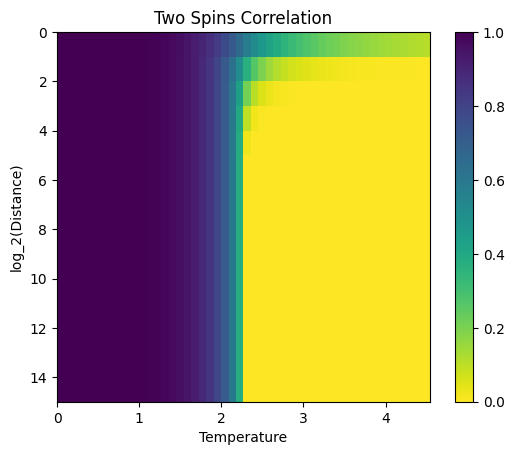

In [7]:
data = np.array(ExpectXX).transpose()

plt.imshow(data, cmap='viridis_r', extent=[0, T[N-1], 15, 0], aspect=0.3)  # 设置颜色映射和范围
plt.colorbar()

# 添加标签和标题
plt.xlabel('Temperature')
plt.ylabel('log_2(Distance)')
plt.title('Two Spins Correlation')

# 显示图形
plt.show()